Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 6404 images belonging to 2 classes.
Found 1601 images belonging to 2 classes.
Epoch 1/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 33s 127ms/step - accuracy: 0.9640 - loss: 0.0971 - val_accuracy: 0.9775 - val_loss: 0.0508
Epoch 2/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 17s 85ms/step - accuracy: 0.9886 - loss: 0.0312 - val_accuracy: 0.9856 - val_loss: 0.0534
Epoch 3/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 18s 88ms/step - accuracy: 0.9952 - loss: 0.0145 - val_accuracy: 0.9856 - val_loss: 0.0518
Epoch 4/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 16s 77ms/step - accuracy: 0.9927 - loss: 0.0168 - val_accuracy: 0.9881 - val_loss: 0.0484
Epoch 5/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 16s 77ms/step - accuracy: 0.9986 - loss: 0.0067 - val_accuracy: 0.9825 - val_loss: 0.0634
Epoch 6/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.9958 - loss: 0.0099 - val_accuracy: 0.9875 - val_loss: 0.0538
Epoch 

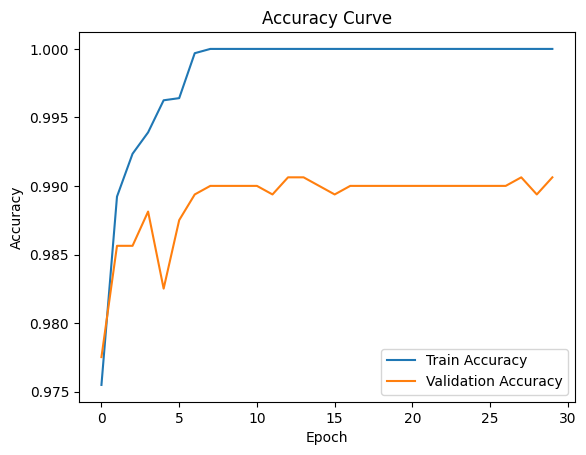

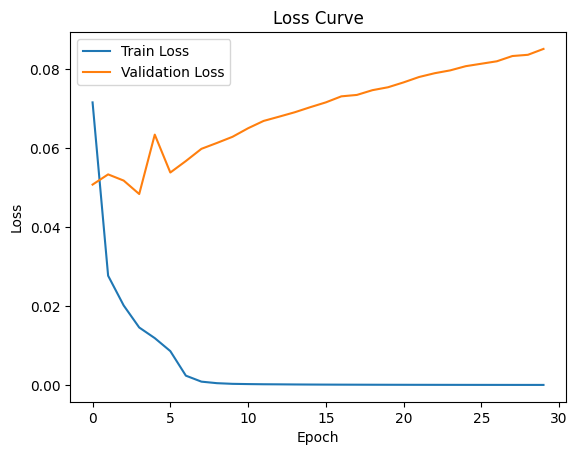

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


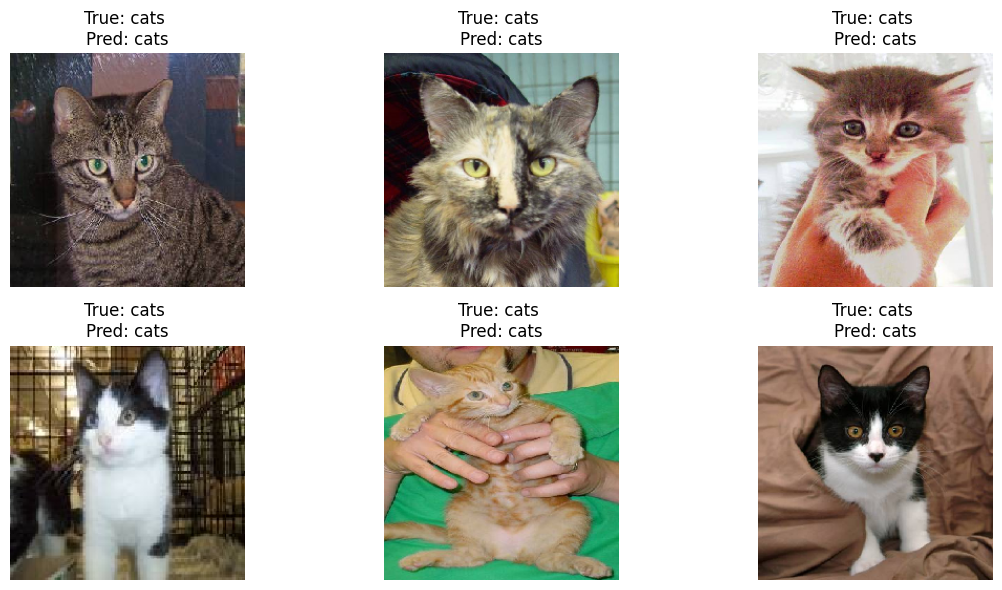

51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step


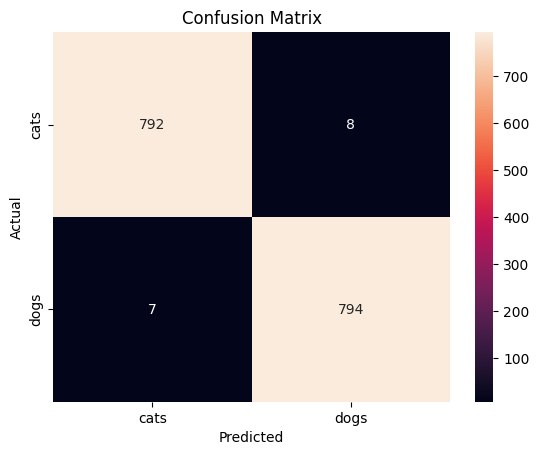

✅ Model saved as cats_vs_dogs_model.h5


In [27]:
# ✅ 1. Install and import required libraries
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix

# ✅ 2. Mount Google Drive (if using Colab)
from google.colab import drive
drive.mount('/content/drive')

# ✅ 3. Unzip your dataset
zip_path = "/content/drive/MyDrive/cat vs dog.zip"
extract_path = "/content/cat_vs_dog"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# ✅ 4. Set up paths and parameters
data_dir = "/content/cat_vs_dog/cat vs dog"
img_size = 224
batch_size = 32

# ✅ 5. Prepare ImageDataGenerators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# ✅ 6. Load pretrained MobileNetV2 and build model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# ✅ 7. Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ✅ 8. Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30
)

# ✅ 9. Evaluate the model
loss, acc = model.evaluate(val_generator)
print(f"\nValidation Accuracy: {acc * 100:.2f}%")

# ✅ 10. Plot accuracy & loss curves
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ✅ 11. Show sample predictions
class_names = list(train_generator.class_indices.keys())
x_test, y_true = next(val_generator)
y_pred_probs = model.predict(x_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow((x_test[i] + 1) / 2)  # un-normalize
    plt.title(f"True: {class_names[int(y_true[i])]} \nPred: {class_names[y_pred[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# ✅ 12. Confusion Matrix
true_labels = val_generator.classes
pred_labels = model.predict(val_generator)
pred_labels = (pred_labels > 0.5).astype(int)

cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ✅ 13. Save the model
model.save("cats_vs_dogs_model.h5")
print("✅ Model saved as cats_vs_dogs_model.h5")


Saving dog.10.jpg to dog.10.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


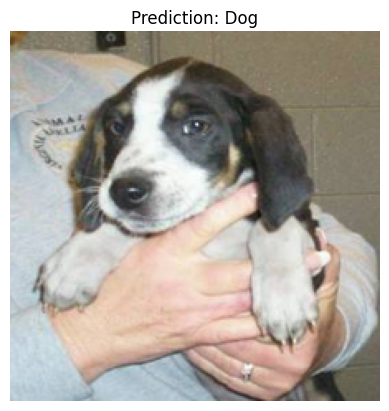

In [28]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image

# ✅ 1. Load the trained model
model = load_model("cats_vs_dogs_model.h5")

# ✅ 2. Upload an image
uploaded = files.upload()  # upload from your device

for fn in uploaded.keys():
    img_path = fn
    img = Image.open(img_path).resize((224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    # ✅ 3. Predict
    prediction = model.predict(img_array)[0][0]
    label = "Dog" if prediction > 0.5 else "Cat"

    # ✅ 4. Show result
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {label}")
    plt.show()
